In [7]:
%load_ext autoreload
%autoreload 2

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.table.plotting import table


ModuleNotFoundError: No module named 'pandas.table'

In [9]:
def pandas2png(df: pd.DataFrame, path: str):
    """
    конвертация пандасовского датафрейма в кртинку png
    """

NameError: name 'pd' is not defined

In [7]:
# пример кода для запуска генератора данных
from data_generator.data_generator import generate_data

N = 5
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21
seed = 10
data = generate_data(N, bounds_params, grid_size, seed)

In [8]:
# Пример данных для NLP постановки
# plu_line - код продуктовой линейки
# plu - код товара
# plu_idx - индекс товара
# P - текущая цена
# Q - текущие продажи в штуках
# E - эластичность
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# x_lower - нижняя граница x для диапазона поиска цены
# x_upper - верхняя граница x для диапазона поиска цены
# x_init - начальное значение x для старта оптимизатора
# fixed - метка, необходимо ли фиксировать x_init цену на товар, по умолчанию всегда 0
data['data_nlp']

,plu_line,P,Q,E,PC,C,plu,plu_idx,x_lower,x_upper,x_init,fixed,x_cur
0,0,68.99,2.469821,-1.117044,60.99,53.08,0,0,0.900000,1.016647,0.958324,0,1.0
1,0,68.99,2.469821,-0.801106,60.99,53.08,1,1,0.900000,1.016647,0.958324,0,1.0
2,1,112.99,2.202904,-0.454934,122.99,72.45,2,2,0.925228,1.100000,1.012614,0,1.0
3,2,163.99,0.887829,-5.005697,176.99,133.79,3,3,0.917382,1.100000,1.008691,0,1.0
4,2,163.99,0.887829,-3.848060,176.99,133.79,4,4,0.917382,1.100000,1.008691,0,1.0


### Отчет по времени работы и количеству "успешно" решенных задач

In [120]:
if 'stats_df' not in globals():
    stats_df = pd.read_csv('./data/optimizers_stats.csv')
stats_df['success'] = stats_df['status'] == 'ok'
time_rep_df = stats_df.groupby(['problem_type', 'solver', 'N'])['t'].describe().reset_index()
stats_df['problem_type'] = np.where(
    stats_df['solver'].isin(['slsqp', 'trust-constr', 'ipopt']), 'nlp', 'lp'
)

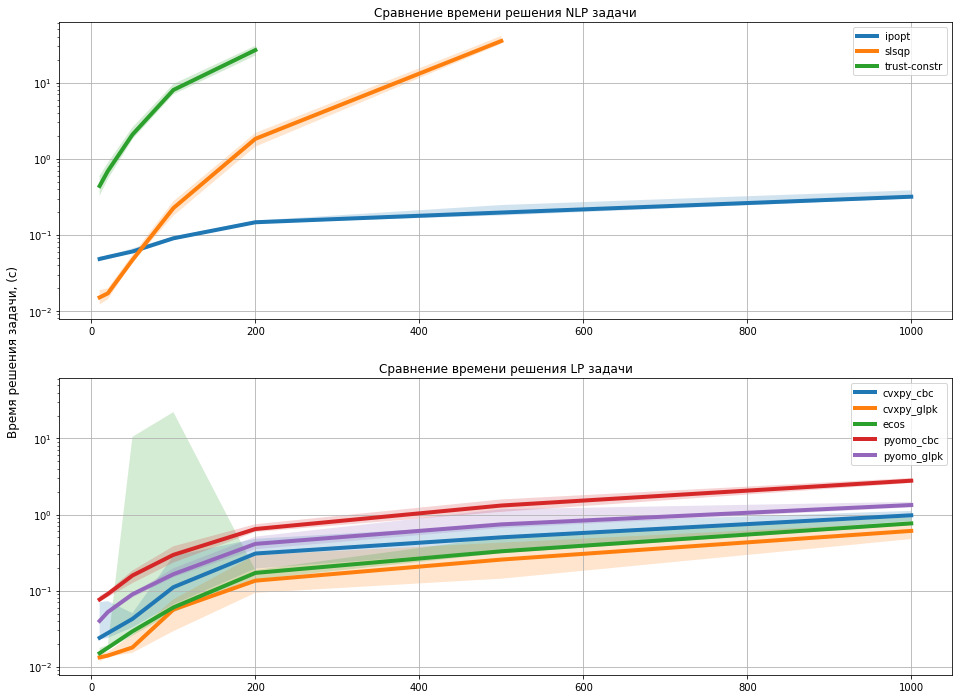

In [330]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharey=True)
for (pr_type, solver), df in time_rep_df.groupby(['problem_type', 'solver']):
    ax_id = 0 if pr_type == 'nlp' else 1
    axes[ax_id].plot(df['N'], df['50%'], lw=4, label=solver)
    axes[ax_id].fill_between(df['N'], df['25%'], df['75%'], alpha=0.2)
axes[0].set_title('Сравнение времени решения NLP задачи')
axes[1].set_title('Сравнение времени решения LP задачи')
# [ax.set_xscale('log') for ax in axes]
[ax.set_yscale('log') for ax in axes]
[ax.legend(loc='upper right') for ax in axes]
[ax.grid() for ax in axes]
fig.text(0.08, 0.5, 'Время решения задачи, (с)', va='center', rotation='vertical', fontdict={'size': 12})
plt.show()

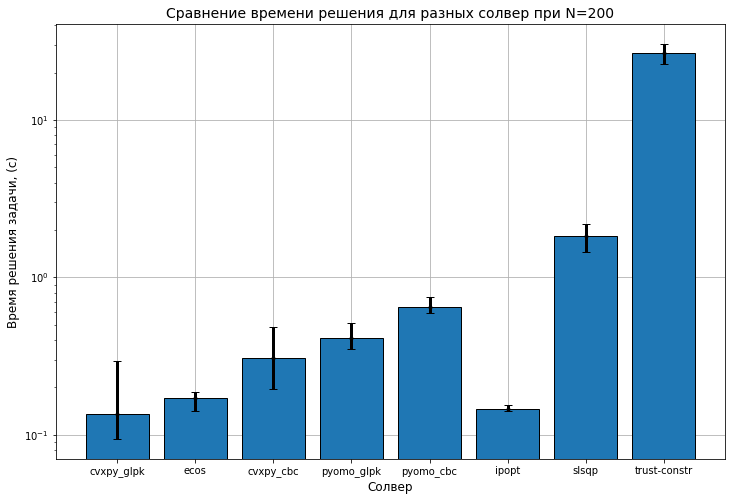

In [271]:
# на примере размерности 200
N_sub = 200
time_rep_sub_df = time_rep_df.query("N==@N_sub")
time_rep_sub_df.sort_values(['problem_type', '50%'], inplace=True)
plt.figure(figsize=(12, 8))
plt.bar(time_rep_sub_df['solver'], time_rep_sub_df['50%'], zorder=2, ec='k')
low = time_rep_sub_df['50%'] - time_rep_sub_df['25%']
upp = time_rep_sub_df['75%'] - time_rep_sub_df['50%']
err_bars = np.vstack([low, upp])
plt.errorbar(time_rep_sub_df['solver'], time_rep_sub_df['50%'], err_bars, zorder=3, color='k', 
             fmt='.', lw=3, capsize=4)
plt.grid()
plt.yscale('log')
plt.xlabel('Солвер', fontdict={'size': 12})
plt.ylabel('Время решения задачи, (с)', fontdict={'size': 12})
plt.title(f'Сравнение времени решения для разных солвер при N={N_sub}', fontdict={'size': 14})
plt.show()

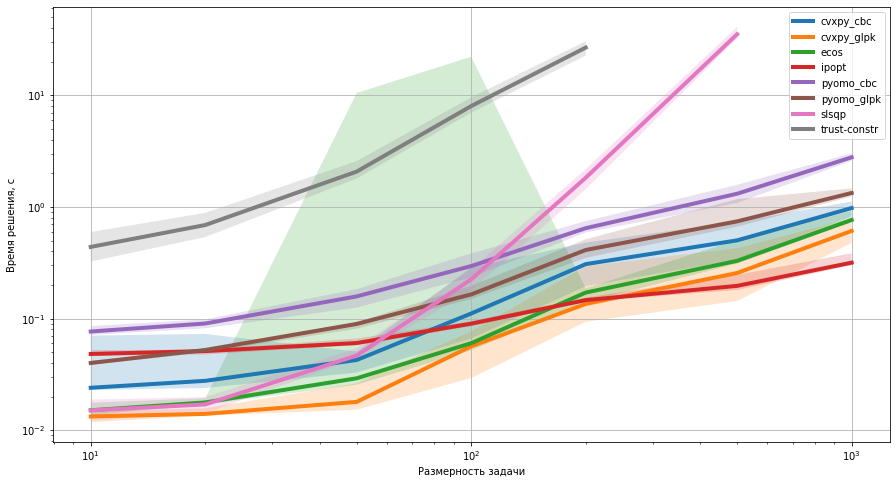

In [103]:
plt.figure(figsize=(15, 8))
for solver, df in time_rep_df.groupby(['solver']):
    plt.plot(df['N'], df['50%'], label=solver, lw=4)
    plt.fill_between(df['N'], df['25%'], df['75%'], alpha=0.2)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Размерность задачи')
plt.ylabel('Время решения, с')
plt.grid()
plt.show()


In [262]:
stats_df.groupby(['solver'])['success'].mean()


solver
cvxpy_cbc       1.000000
cvxpy_glpk      1.000000
ecos            0.777143
ipopt           1.000000
pyomo_cbc       1.000000
pyomo_glpk      1.000000
slsqp           1.000000
trust-constr    0.960000
Name: success, dtype: float64

In [ ]:
stats_df.query("not success")

In [381]:
data_c = generate_data(100, 5)
data_c = construct_bounds(data_c, bounds_params)
# генерация данных для MILP оптимизации
data_d = construct_lp_grid(data_c, bounds_params, 21)
M_cur = sum(data_c['Q'] * (data_c['P'] - data_c['C']))
P_cur = sum(data_c['Q'] * data_c['P'])

opt_params = {
    'alpha': 0.0,
    'con_mrg': M_cur,
    'con_equal': True
}

In [382]:
%%time
res1, t1 = pricing_optimization(data_c, ScipyNlpOptimizationModel, opt_params, 'slsqp', 
                                solver_option={'max_iters': 10000})
res2, t2 = pricing_optimization(data_c, PyomoNlpOptimizationModel, opt_params, 'ipopt')


CPU times: user 210 ms, sys: 15.9 ms, total: 226 ms
Wall time: 264 ms


In [401]:
res3, t3 = pricing_optimization(data_d, CvxpyLpOptimizationModel, opt_params, 'CBC')
